# A/B-тестирование рекомендательной системы

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Оценка-корректности-проведения-теста" data-toc-modified-id="Оценка-корректности-проведения-теста-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Оценка корректности проведения теста</a></span><ul class="toc-item"><li><span><a href="#Проверим-данные-на-соответствие-требованиям-технического-задания." data-toc-modified-id="Проверим-данные-на-соответствие-требованиям-технического-задания.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверим данные на соответствие требованиям технического задания.</a></span></li><li><span><a href="#Проверка-времени-проведения-теста." data-toc-modified-id="Проверка-времени-проведения-теста.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверка времени проведения теста.</a></span></li><li><span><a href="#Проверка-аудитории-теста." data-toc-modified-id="Проверка-аудитории-теста.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка аудитории теста.</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Оценка-результатов-A/B-тестирования" data-toc-modified-id="Оценка-результатов-A/B-тестирования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка результатов A/B-тестирования</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

**Задача исследования** — провести оценку результатов A/B-теста. 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.  А/В тест проводился с целью протестировать изменения, связанные с внедрением улучшенной рекомендательной системы. Ожидается, что за 14 дней с момента регистрации пользователи покажут улучшение трех контрольных метрик не менее чем на 10%.

**Этапы исследования:** 
- Обзор и предобработка данных 
- Оценка корректности проведения теста
- Исследовательский анализ данных
- Анализ результатов A/B-тестирования
- Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Общее заключение о корректности проведения теста.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Обзор и предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import numpy as np
import math as mth
from scipy import stats as st
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:,.2f}'.format)

### Обзор данных

Загрузим и изучим данные. Сохраним в переменные. 

In [2]:
events = pd.read_csv('/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
def info (df):               # функция для общего обзора данных датасета
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(df.head(5))
    print(f'В таблице строк: {df.shape[0]}, столбцов: {df.shape[1]} ')
    print('Количество дубликатов:', df.duplicated().sum())
    print('Процент дубликатов: ', "{:.2%}".format((df.duplicated().sum()/df.shape[0])))
    tbl = pd.concat([df.dtypes, df.isna().sum(), round((df.isna().mean()*100),2), ], axis=1, 
                   keys=["Тип данных", "Кол-во пропусков", "% пропусков", ])
    display(tbl)


- **Действия новых пользователей**

In [4]:
info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В таблице строк: 440317, столбцов: 4 
Количество дубликатов: 0
Процент дубликатов:  0.00%


,Тип данных,Кол-во пропусков,% пропусков
user_id,object,0,0.00
event_dt,object,0,0.00
event_name,object,0,0.00
details,float64,377577,85.75


Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

В таблице большой процент пропусков в колонке `details`, это дополнительные данные о событии, вероятно, они заполняются не для каждого события. Для нашего исследования эта информация не важна, пропуски можем игнорировать.

Необходимо будет преобразовать столбец с датой в формат datetime.

In [5]:
events['event_dt'].sort_values().unique()

array(['2020-12-07 00:00:33', '2020-12-07 00:00:34',
       '2020-12-07 00:00:35', ..., '2020-12-30 23:02:44',
       '2020-12-30 23:36:30', '2020-12-30 23:36:33'], dtype=object)

У нас есть данные о действиях новых пользователей за период с 7 декабря по 30 декабря 2020г. 

In [6]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Даны 4 типа событий: 
- вход (login)
- переход на страницу продукта (product_page)
- просмотр корзины (product_cart)
- покупка  (purchase)

In [7]:
events['user_id'].nunique()

58703

В таблице данные о действиях 58703 новых пользователей. 

- **Календарь маркетинговых событий на 2020 год.**

In [8]:
info(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


В таблице строк: 14, столбцов: 4 
Количество дубликатов: 0
Процент дубликатов:  0.00%


,Тип данных,Кол-во пропусков,% пропусков
name,object,0,0.00
regions,object,0,0.00
start_dt,object,0,0.00
finish_dt,object,0,0.00


Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [9]:
marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

Есть данные о 14 событиях за 2020 год. 

In [10]:
marketing_events['regions'].value_counts()

APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64

События проводились в четырех регионах (Азиатско-Тихоокеанский, Европа, Северная Америка, СНГ)

Необходимо будет преобразовать столбцы с датой в формат datetime.

- **Новые пользователи**

In [11]:
info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


В таблице строк: 61733, столбцов: 4 
Количество дубликатов: 0
Процент дубликатов:  0.00%


,Тип данных,Кол-во пропусков,% пропусков
user_id,object,0,0.00
first_date,object,0,0.00
region,object,0,0.00
device,object,0,0.00


Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [12]:
new_users['first_date'].sort_values().unique()

array(['2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
       '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14',
       '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18',
       '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22',
       '2020-12-23'], dtype=object)

Даты регистрации новых пользователей с 7 по 23 декабря 2020 года.

In [13]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Пользователи регистрировались с 4 различных устройств (PC, Android, iPhone, Mac). 

In [14]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Новые пользователи были из 4 регионов.

Необходимо будет преобразовать столбцы с датой в формат datetime.

- **Таблица участников тестов**

In [15]:
info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


В таблице строк: 18268, столбцов: 3 
Количество дубликатов: 0
Процент дубликатов:  0.00%


,Тип данных,Кол-во пропусков,% пропусков
user_id,object,0,0.00
group,object,0,0.00
ab_test,object,0,0.00


Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [16]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В таблице находятся участники двух А/В тестов: recommender_system_test, interface_eu_test. 

In [17]:
len(participants) - participants['user_id'].nunique()

1602

Кол-во уникальных пользователей не совпадает с кол-вом строк в таблице, 1602 пользователя участвовали в обоих тестах. В дальнейшем нас интересует только тест `recommender_system_test`. Желательно удалить пользователей, которые пересекаются. Обработаем эти данные в разделе `Оценка корректности проведения теста`.

### Предобработка данных

Приведем даты в таблицах к нужному формату `datetime`. 

In [18]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date']).astype("datetime64[D]")

Мы преобразовали формат даты. Других ошибок для исправления на данном этапе нет. Можно переходить к оценке корректности теста.

**Вывод**

Мы подробно рассмотрели каждый из данных датасетов, привели к нужному формату даты и определили для себя дальнейшее направление исследования. Следует оценить корректность проведения теста, выявить возможные ошибки. 

## Оценка корректности проведения теста

### Проверим данные на соответствие требованиям технического задания. 

Название нужного теста `recommender_system_test`, отфильтруем таблицу участников теста `participants` в новую таблицу. 

In [19]:
participants_selected = participants.query('ab_test == "recommender_system_test"')
participants_selected.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Проверим разбивку на группы

In [20]:
print(len(participants_selected))
participants_selected.groupby('group')['group'].count()

6701


group
A    3824
B    2877
Name: group, dtype: int64

In [21]:
print('Разница в количестве пользователей между группами А и В: ', "{:.2%}".format(3824 / 2877 - 1))

Разница в количестве пользователей между группами А и В:  32.92%


В нужном нам тесте 6701 участник, в группе А - 3824 участника, в группе В - 2877.

По ТЗ дата запуска теста: 7 декабря 2020 года, дата остановки: 4 января 2021 года. В таблице `events` есть данные о действиях пользователей только до 30 декабря 2020г. Обратим на это внимание.

По ТЗ дата остановки набора новых пользователей: 2020-12-21. В базе данные о пользователях до 23 декабря. Отфильтруем данные, запишем в новую таблицу.

In [22]:
new_users_act_period = new_users[new_users['first_date'] <= "2020-12-21"]
len(new_users) - len(new_users_act_period)

5263

Количество новых пользователей сократилось на 5263 человека.

Объединим таблицы, чтобы проверить другие условия ТЗ.

In [23]:
ab_test = participants_selected.merge(events, how='left',  on='user_id').merge(new_users_act_period, how='left', on='user_id').reset_index(drop=True)                  
ab_test.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC


In [24]:
ab_test['user_id'].nunique()

6701

Количество уникальных пользователей АВ теста на данном этапе 6701, на данном этапе на 701 больше, чем в ТЗ. 

### Проверка времени проведения теста. 

Проверим, не совпадает ли время проведения теста с маркетинговыми и другими активностями.


In [25]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [26]:
ab_test.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC


In [27]:
ab_test['marketing_event'] = ''

for i in range(len(ab_test)):
    for row in range(len(marketing_events)):
        start_date = marketing_events['start_dt'][row]
        end_date = marketing_events['finish_dt'][row]
        regions = marketing_events['regions'][row].split(', ')
        if start_date <= ab_test['event_dt'][i] <= end_date:
            for region in range(len(regions)):
                if ab_test['region'][i] == regions[region]:
                    ab_test['marketing_event'][i] = marketing_events['name'][row]

ab_test['marketing_event'].unique()                    

array(['', 'Christmas&New Year Promo'], dtype=object)

In [28]:
ab_test.query('marketing_event == "Christmas&New Year Promo"')['user_id'].nunique()

1220

In [29]:
ab_test.query('marketing_event == "Christmas&New Year Promo"').groupby("group")['user_id'].nunique()

group
A    991
B    229
Name: user_id, dtype: int64

В данных есть пересечение 1220 пользователей с одной акцией `Christmas&New Year Promo`. Акция могла повлиять на итоги А/В теста, однако, исключив этих пользователей, мы сильно уменьшаем количество участников нашего теста, что тоже не очень хорошо. Отметим эту проблему, но оставим данные без изменений на данном этапе.

### Проверка аудитории теста. 

Проверим, есть ли пересечения пользователей с конкурирующим тестом и есть ли пользователи, участвующие в двух группах нашего теста одновременно. В конкурирующем тесте нас будут интересовать только пользователи группы В, т.к. только они видели изменения на сайте.

In [30]:
a = set(ab_test.query('group == "A"')['user_id']) # пользователи группы А нужного теста
b = set(ab_test.query('group == "B"')['user_id']) # пользователи группы В нужного теста

b2 = participants.query('ab_test == "interface_eu_test"')  
b2 = set(b2.query('group == "B"')['user_id'])   # пользователи группы В конкурирующего теста

In [31]:
print('Количество пересечений в группах А и В: ', len(a.intersection(b)))
print('Количество пересечений в группах A и В2: ', len(a.intersection(b2)))
print('Количество пересечений в группах В и В2: ', len(b.intersection(b2)))

Количество пересечений в группах А и В:  0
Количество пересечений в группах A и В2:  439
Количество пересечений в группах В и В2:  344


In [32]:
intersection = a.intersection(b2).union(b.intersection(b2))
len(intersection)

783

Участие 783 человек сразу в двух в тестах могло повлиять на результаты нашего теста. Нам не известны подробности конкурирующего теста, даты и условия. Исключим на данном этапе пользователей, которые пересекаются с группой В2.

In [33]:
ab_test = ab_test.query('user_id not in @intersection')
ab_test['user_id'].nunique()

5918

Количество участников теста стало меньше ожидаемого по ТЗ на 82 человека, это не слишком значимое сокращение.

**Подсчитаем долю пользователей из EU**, которые участвовали в тесте, от количества всех новых пользователей из этого региона, зарегистрированных на ресурсе в период набора пользователей в тест.

In [34]:
ab_test_users_eu = ab_test[ab_test['region'] == "EU"]['user_id'].nunique()  # пользователи из региона EU, участвующие в тесте
ab_test_users_eu

5568

In [35]:
new_users_eu = new_users_act_period[new_users_act_period['region'] == "EU"][['user_id']]  # новые пользователи из EU региона
len(new_users_eu)

42340

In [36]:
ab_test_users_eu / len(new_users_eu) * 100

13.150684931506849

Получили 13% участников, что меньше заявленному по ТЗ размеру в 15%. 

**Проверим равномерность распределения по тестовым группам и правильность их формирования.**

In [37]:
ab_test.groupby("group")['user_id'].nunique()

group
A    3385
B    2533
Name: user_id, dtype: int64

In [38]:
print('Разница в количестве пользователей между группами А и В: ', "{:.2%}".format(3385 / 2533 - 1))

Разница в количестве пользователей между группами А и В:  33.64%


Тестовые группы не одинаковые по количеству участников, но для проверки относительных показателей нам это не так важно.

Проверим как распределены участники тестовых групп по регионам и по типам устройств.

region,APAC,CIS,EU,N.America
group,,,,
A,37,25,3195,128
B,35,30,2373,95


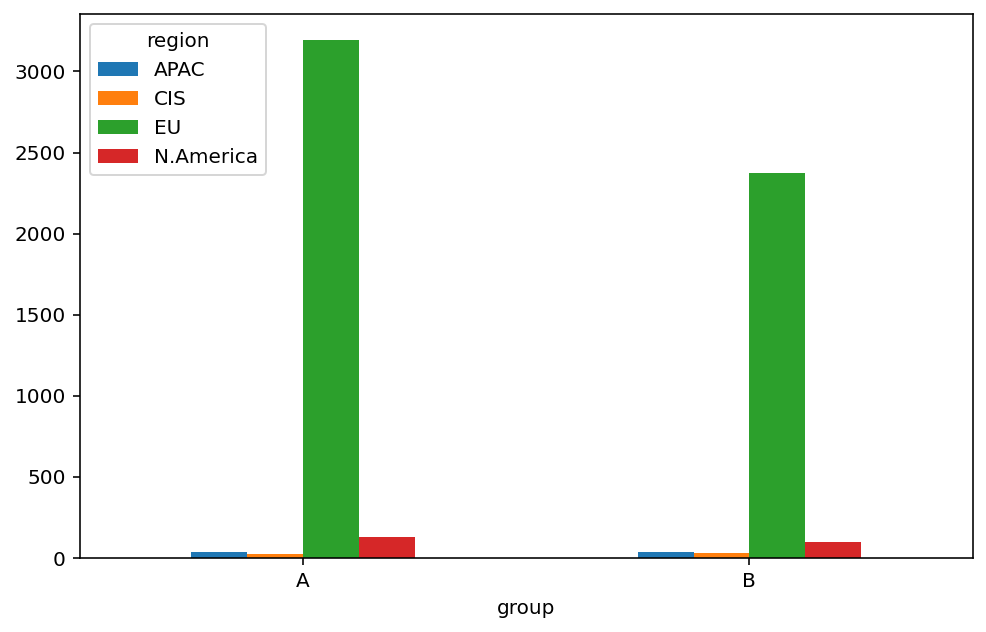

In [39]:
fig = ab_test.pivot_table(index='group', columns="region", values='user_id', aggfunc='nunique')
display(fig)
fig.plot(kind='bar', figsize=(8, 5))
plt.xticks(rotation=0);

device,Android,Mac,PC,iPhone
group,,,,
A,1488,314,883,700
B,1168,220,612,533


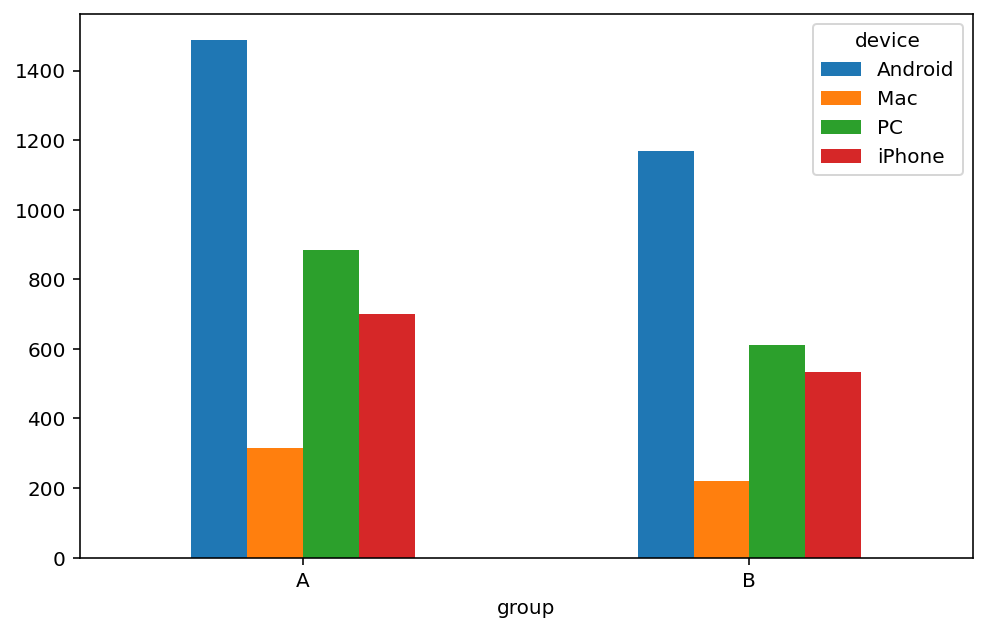

In [40]:
fig = ab_test.pivot_table(index='group', columns="device", values='user_id', aggfunc='nunique')
display(fig)
fig.plot(kind='bar', figsize=(8, 5))
plt.xticks(rotation=0);

Можно сказать, что распределение по регионам и типам устройств в группах А и В примерно одинаковое. Обратим внимание, что проводить тестирование на разных типах устройств одновременно может также искажать результаты теста. 

Удалим из объединенной таблицы лишние колонки и добавим колонку с выделенной датой совершения события.

In [41]:
ab_test = ab_test.drop(['ab_test', 'details'], axis=1)
ab_test['event_date'] = ab_test['event_dt'].astype("datetime64[D]")
ab_test.head(3)

,user_id,group,event_dt,event_name,first_date,region,device,marketing_event,event_date
0,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,purchase,2020-12-07,EU,PC,,2020-12-07
1,D1ABA3E2887B6A73,A,2020-12-25 00:04:56,purchase,2020-12-07,EU,PC,Christmas&New Year Promo,2020-12-25
2,D1ABA3E2887B6A73,A,2020-12-07 14:43:29,product_cart,2020-12-07,EU,PC,,2020-12-07


Проверим динамику набора пользователей в группы по дням.

first_date
2020-12-21    639
2020-12-14    590
2020-12-07    558
2020-12-13    522
2020-12-20    438
2020-12-12    434
2020-12-19    382
2020-12-10    345
2020-12-18    343
2020-12-08    317
2020-12-15    314
2020-12-17    313
2020-12-16    254
2020-12-11    247
2020-12-09    222
Name: user_id, dtype: int64

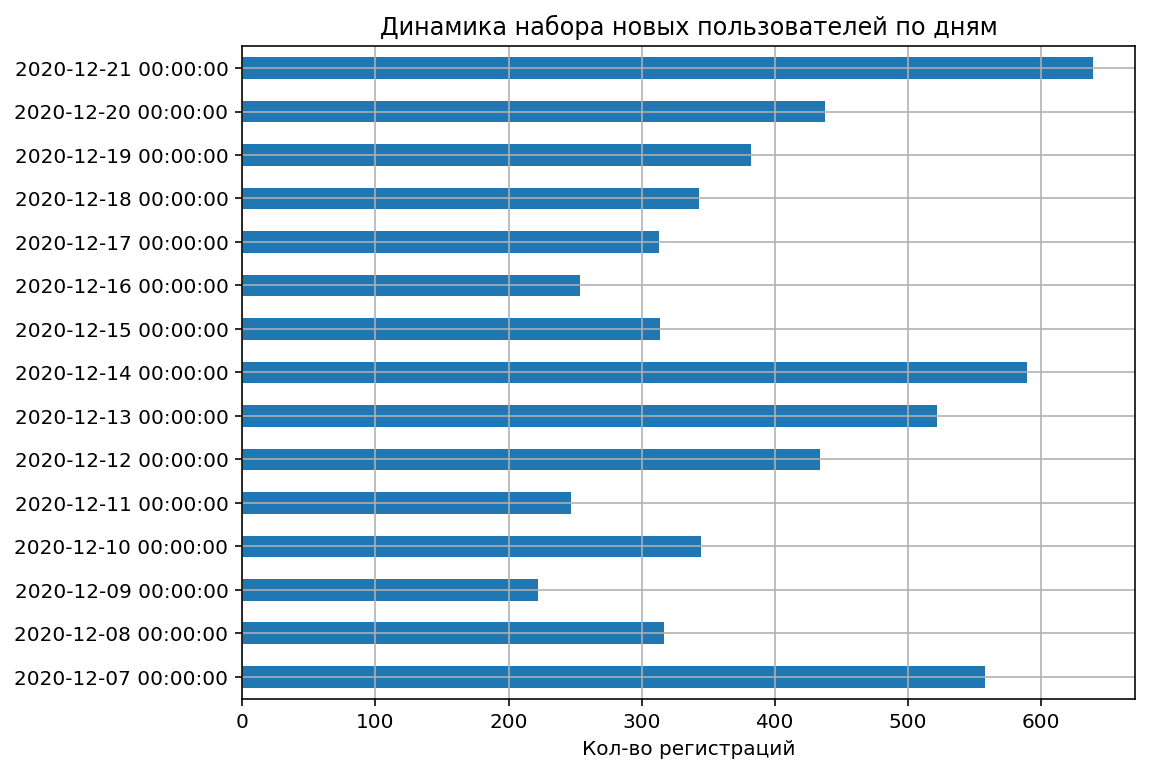

In [42]:
fig = ab_test.groupby('first_date')['user_id'].nunique()
display(fig.sort_values(ascending=False))
fig.plot(kind='barh', figsize=(8,6), grid=True)
plt.title('Динамика набора новых пользователей по дням')
plt.xlabel('Кол-во регистраций')
plt.ylabel(None);

Динамика регистрации новых пользователей волнообразная. В пиковые дни кол-во регистраций почти в 3 раза больше, чем в дни спада. Больше всего регистраций было 7, 14, 21 декабря. Меньше всего - 9, 11, 16 декабря. 

Рассмотрим динамику набора пользователей с разбивкой по тестовым группам.

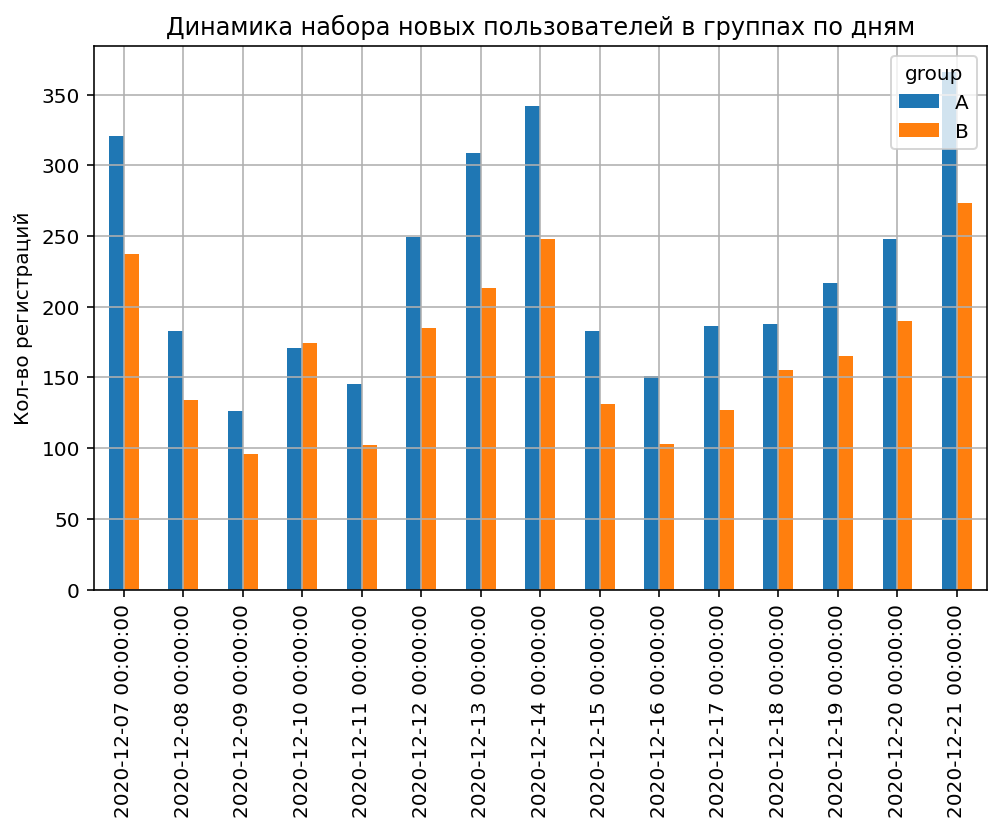

In [43]:
fig = ab_test.pivot_table(index='first_date', columns='group', values='user_id', aggfunc='nunique')
fig.plot(kind='bar', figsize=(8,5), grid=True)
plt.title('Динамика набора новых пользователей в группах по дням')
plt.ylabel('Кол-во регистраций')
plt.xlabel(None);

Можно сказать, что набор в две группы идет равномерно. Рисунок диаграммы соответствует диаграмме общего набора. Кол-во пользователей в группе А больше, чем в группе В, мы видели это при анализе участников. Исключением является только 10 декабря, когда кол-во регистраций в группе В превысило ко-во регистраций в группе А. 

**Вывод**

Данные не в полной мере соответствуют техническому заданию. На этапе оценки корректности проведения теста можно сделать следующие выводы: 

- В таблице `events` есть данные о действиях пользователей только до 30 декабря 2020г, а дата остановки теста по ТЗ: 4 января 
- Баланс между группами примерно 75/25. При проверке относительных значений это не так важно, но для абсолютных показателей эксперименты стоит запускать с балансом 50/50.
- В базе данные о пользователях до 23 декабря, по ТЗ окончание набора пользователей 21 декабря. Мы отфильтровали лишние данные.
- обнаружено пересечение 1220 участников теста с новогодней акцией. Таких участников стоит удалять, но мы оставили.
- пересечений между пользователями нашего теста не обнаружено, но есть пересечение 783 человек с конкурирующим тестом (тестовой группой). Таких пользователей мы исключили. 
- количество участников теста уменьшилось до 5918 человек. Если бы мы фильтровали участников по всем найденным ошибкам, то выборки стали бы гораздо меньше ожидаемых. 
- доля новых пользователей из EU - 13%, что меньше заявленному по ТЗ размеру в 15%.
- тестирование проводилось без разделения по типам устройств пользователей, но распределение по этому параметру в выборках примерно одинаковое.
- график регистрации новых пользователей по дням волнообразный, с резкими пиками и спадами. 
      

## Исследовательский анализ данных

In [44]:
ab_test.head(3)

,user_id,group,event_dt,event_name,first_date,region,device,marketing_event,event_date
0,D1ABA3E2887B6A73,A,2020-12-07 14:43:27,purchase,2020-12-07,EU,PC,,2020-12-07
1,D1ABA3E2887B6A73,A,2020-12-25 00:04:56,purchase,2020-12-07,EU,PC,Christmas&New Year Promo,2020-12-25
2,D1ABA3E2887B6A73,A,2020-12-07 14:43:29,product_cart,2020-12-07,EU,PC,,2020-12-07


Посчитаем, как часто совершались события, сколько пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали событие.

In [45]:
table_events = pd.concat([ab_test['event_name'].value_counts(),
          ab_test.groupby('event_name')['user_id'].nunique(), 
          ab_test.groupby('event_name')['user_id'].nunique() / ab_test['user_id'].nunique() *100,], 
          axis=1, 
          keys=["count", "users", "% "],)
table_events

,count,users,%
login,9901,3244,54.82
product_page,6116,2030,34.30
purchase,2939,999,16.88
product_cart,2886,953,16.10


Предполагаем, что воронка стрится следующим образом: `login` → `product_page` → `product_cart` → `purchase`. Обратим внимание, что кол-во пользователей совершивших покупку выше, чем ко-во пользователей просмотревших корзину. Возможно это особенность сайта или техническая ошибка.

Только около 55% пользователей залогинились на сайте после регистрации и около 17% совершили покупку. Получается, что около 45% зарегистрированных пользователей не совершали никаких действий после регистрации.

 **Посмотрим как распределено количество событий на пользователя в выборках.** 

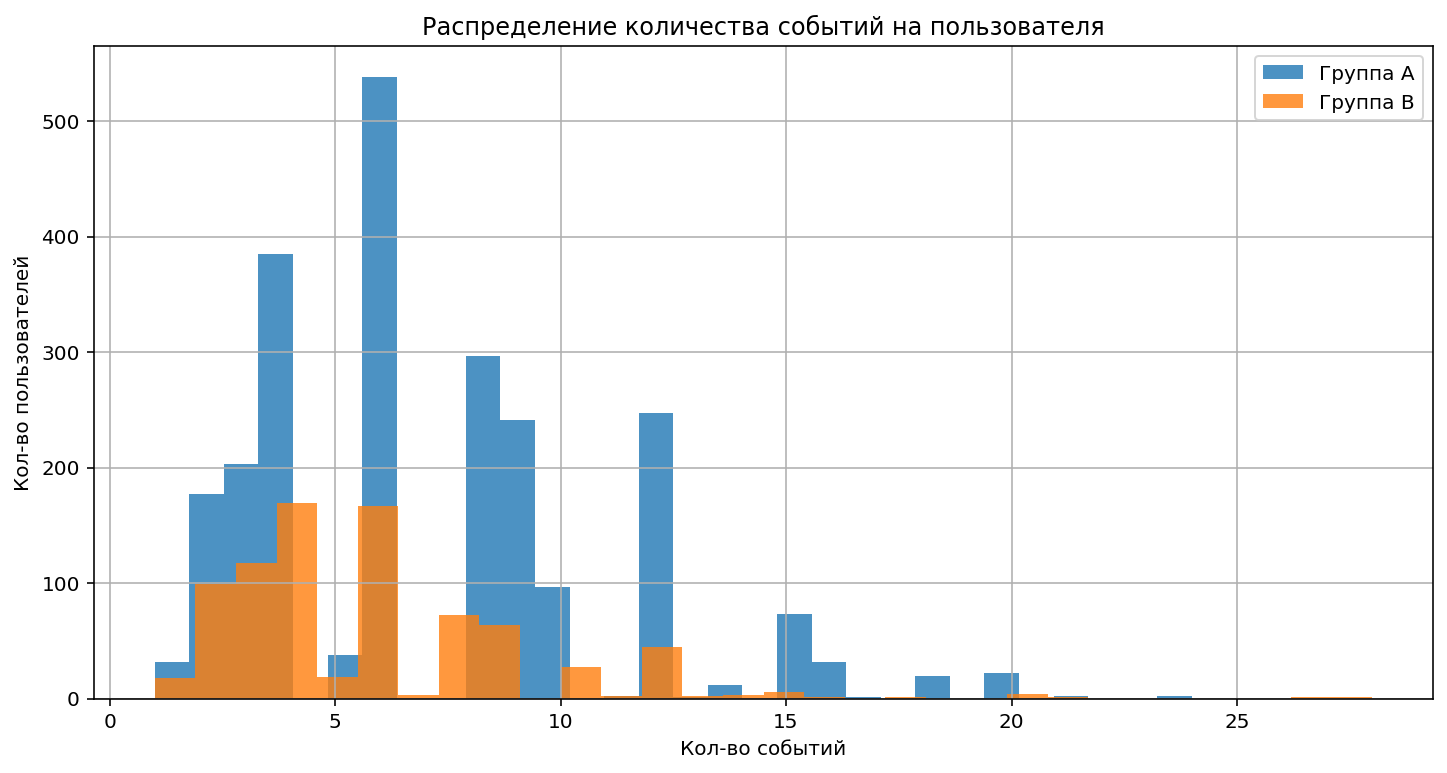

In [46]:
A = ab_test.query('group == "A"').groupby('user_id')['event_name'].count().reset_index()
A = A[A['event_name'] != 0]
B = ab_test.query('group == "B"').groupby('user_id')['event_name'].count().reset_index()
B = B[B['event_name'] != 0]

A['event_name'].hist(bins=30, figsize=(12,6), label='Группа A', alpha=0.8);
B['event_name'].hist(bins=30, label='Группа B', alpha=0.8)
plt.legend()
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей');

Судя по графику, тип распределения по количеству событий на пользователя в двух группах в целом схож. Распределение похоже на нормальное. 

**Посмотрим как число событий в выборках распределено по дням.**

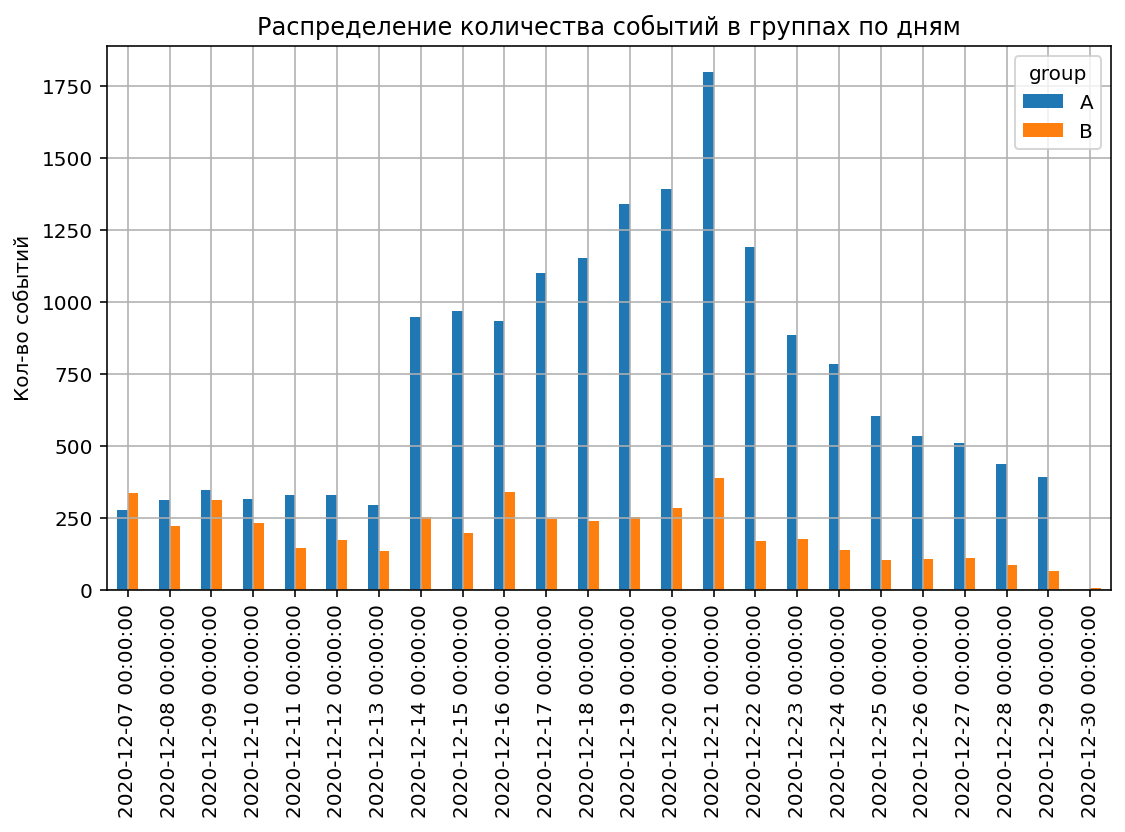

In [47]:
fig = ab_test.pivot_table(index='event_date', columns='group', values='event_name', aggfunc='count')
fig.plot(kind='bar', figsize=(9,5), grid=True)
plt.title('Распределение количества событий в группах по дням')
plt.ylabel('Кол-во событий')
plt.xlabel(None);

В тестовой выборке после 14 декабря видим гораздо меньше событий, чем в контрольной. До 14 декабря наблюдаем стабильные значения, после 14 декабря резкий рост в контрольной выборке. Пиковое значениие 21 декабря. Далее плавный спад в обеих выборках. 30 декабря почти нет событий. 

**Посмотрим как меняется конверсия в воронке в выборках на разных этапах.**

Создадим сводную таблицу, где для каждой группы будет указано число уникальных пользователей, совершивших то или иное действие.

In [48]:
group_pivot = (ab_test
               .pivot_table(index='event_name', columns='group', values='user_id', aggfunc="nunique")
               .sort_values(by="A", ascending=False)
              )
new_index = ['login', 'product_page', 'product_cart', 'purchase']
group_pivot = group_pivot.reindex(new_index).reset_index()
group_pivot

group,event_name,A,B
0,login,2422,822
1,product_page,1571,459
2,product_cart,728,225
3,purchase,773,226


Отобразим воронку событий. Выведем данные о количестве пользователей на каждом шаге и отношение пользователей на определенном шаге к шагу 1. 

In [49]:
fig = go.Figure(go.Funnel(
    name='A',
    y = group_pivot['event_name'],
    x = group_pivot["A"],
    textinfo = 'value+percent initial'))

fig.add_trace(go.Funnel(
    name='B',
    y = group_pivot['event_name'],
    x = group_pivot["B"],
    textinfo = "value+percent initial"))
    
fig.update_layout(title="Воронка событий с расчетом конверсии к 'login'")
fig.show()

- Данные в последних шагах (purchase и product_cart) практически идентичны. 
- На втором шаге (product_page) отсеилось в группе А - 35%, в группе В - 44%. 
- На третьем шаге (purchase) отсеилось по 51% в группах А и В.  
- Конверсия на втором шаге в группе А - 65%, в группе В - 56%. 
- Конверсия от первого шага на третьем шаге в группе А - 32%, в группе В - 27%. 

По ТЗ нам необходимо посчитать изменение метрик за 14 дней. Проверим, что все пользователи "проживают" не менее 14 дней. Отфильтруем тех, кто зарегистрировался после 16 декабря, менее чем за 14 дней до завершения тест. Напомним, что в наших данных данные до 30 декабря, а не до 4 января, как указано в ТЗ. 

In [50]:
ab_test.query('first_date > "2020-12-16"')['user_id'].nunique()

2115

Целых 2115 пользователей "прожили" менее 14 дней. Для чистоты исследования таких пользователей стоит исключать. Если сделаем это на текущих данных, значительно уменьшится количество участников теста. 

**Опишем какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию.**

Исследовательский анализ данных показал:
- около 45% зарегистрированных пользователей не совершали никаких действий после регистрации
- кол-во пользователей совершивших покупку немонго выше, чем ко-во пользователей просмотревших корзину
- после 14 декабря отмечаем резкое увеличение кол-ва событий в контрольной группе, с пиком 21 декабря.
- 2115 пользователей "прожили" менее 14 дней. Таких пользователей также следовало бы исключать. 
- в продуктовой воронке видим значительный отсев пользователей на 2 и 3 шагах. Отсев на втором шаге 35 и 44 процентов пользователей, на третьем - 51%
- конверсия в тестовой группе ниже, чем в контрольной.


## Оценка результатов A/B-тестирования

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.


По графику воронки видим, что показатели тестовой группы показали не улучшение, а ухудшение конверсии по всем трем метрикам, по сравнению с контрольной группой.

- конверсия в просмотр карточек *ухудшилась на 9%*
- конверсия в просмотр корзины *ухудшилась на 5%*
- конверсия в покупку *ухудшилась на 3%*

Такие показатели скорее всего связаны с теми ошибками в проведении теста, которые мы рассмотрели выше. 

- **Проверим статистическую разницу долей z-критерием.**

Напишем функцию для проверки разницы долей между группами А и В на каждом шаге воронки. Возьмем число пользователей, совершивших  событие в каждой из групп. Посчитаем долю пользователей, совершивших это событие от общего количества пользователей. Проверим, будет ли отличие между группами статистически достоверным.

- Н0: доли пользователей, совершивших действие, для групп А и В одинаковые. 
- Н1: есть статистически значимые различия между долями в группах А и В.

In [51]:
def equity_hypothesis (event_name, group1, group2, alpha):
    
    alpha = alpha 

    event_size1 = group_pivot[group_pivot['event_name'] == event_name][group1].iloc[0] 
    group_size1 = ab_test[ab_test['group'] == group1]['user_id'].nunique()  

    event_size2 = group_pivot[group_pivot['event_name'] == event_name][group2].iloc[0] 
    group_size2 = ab_test[ab_test['group'] == group2]['user_id'].nunique()  

     # пропорция успехов в группе 1:
    p1 = event_size1 / group_size1

    # пропорция успехов во группе 2:
    p2 = event_size2 / group_size2

    # пропорция успехов в комбинированном датасете:
    p_combined = (event_size1 + event_size2) / (group_size1 + group_size2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
       p_combined * (1 - p_combined) * (1 / group_size1 + 1 / group_size2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Событие: {event_name}')
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: между долями групп {group1} и {group2} есть значимая разница')
        print()
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп {group1} и {group2} разными')

In [52]:
equity_hypothesis ('product_page', "A", "B", 0.05)
equity_hypothesis ('product_cart', "A", "B", 0.05)
equity_hypothesis ('purchase', "A", "B", 0.05)

Событие: product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями групп A и B есть значимая разница

Событие: product_cart
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями групп A и B есть значимая разница

Событие: purchase
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями групп A и B есть значимая разница



Тест показал различия в долях групп на всех шагах воронки.

## Общие выводы

По итогам исследования можно сделать вывод о том, что тест был проведен некорректно. Итоговые результаты не могут быть использованы для принятия решения по вопросу внедрения улучшенной рекомендательной системы.

Результат А/В теста показал снижение конверсии по всем метрикам (на 9%, 5% и 3%), вместо ожидаемого увеличения. 
Исследовательский анализ данных показал наличие большого количества ошибок. Не все пункты ТЗ были выполнимы в рамках имеющихся данных. Фильтрация данных с целью уменьшения влияния ошибок в данном случае привела бы к значительному сокращению выборок, и как следствие, к недостоверному результату. Мы исключили только часть пользователей,  чтобы сохранить баланс размера выборок и качества данных, однако, тест все равно нельзя считать успешным. 

Основные обнаруженные недостатки в данных:
- тест проводился параллельно с новогодней акцией, это затронуло 1220 участников
- есть пересечение 783  пользователей с другим А/В тестом, условия и сроки которого нам не известны.
- тестирование проводилось без разделения по типам устройств пользователей
- В таблице `events` есть данные о действиях пользователей только до 30 декабря
- лайфтайм 2115 пользователей менее 14 дней, необходимых для теста
- кол-во пользователей совершивших покупку немонго выше, чем ко-во пользователей просмотревших корзину
- график регистрации новых пользователей по дням волнообразный, с резкими пиками и спадами.
- группы А и В несбалансированны, группа А примерно на 33% больше группы В.
- после 14 декабря отмечаем резкое увеличение кол-ва событий только в контрольной группе А, с пиком 21 декабря.
